<a href="https://colab.research.google.com/github/SIT-AIRD-Center/Jalan-Scraping/blob/main/jalan_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

じゃらんの観光地レビューをスクレイピングします

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import sys
import json
import shutil
import requests
from lxml import html
from lxml.etree import tostring

カテゴリーIDは以下のように確認できる

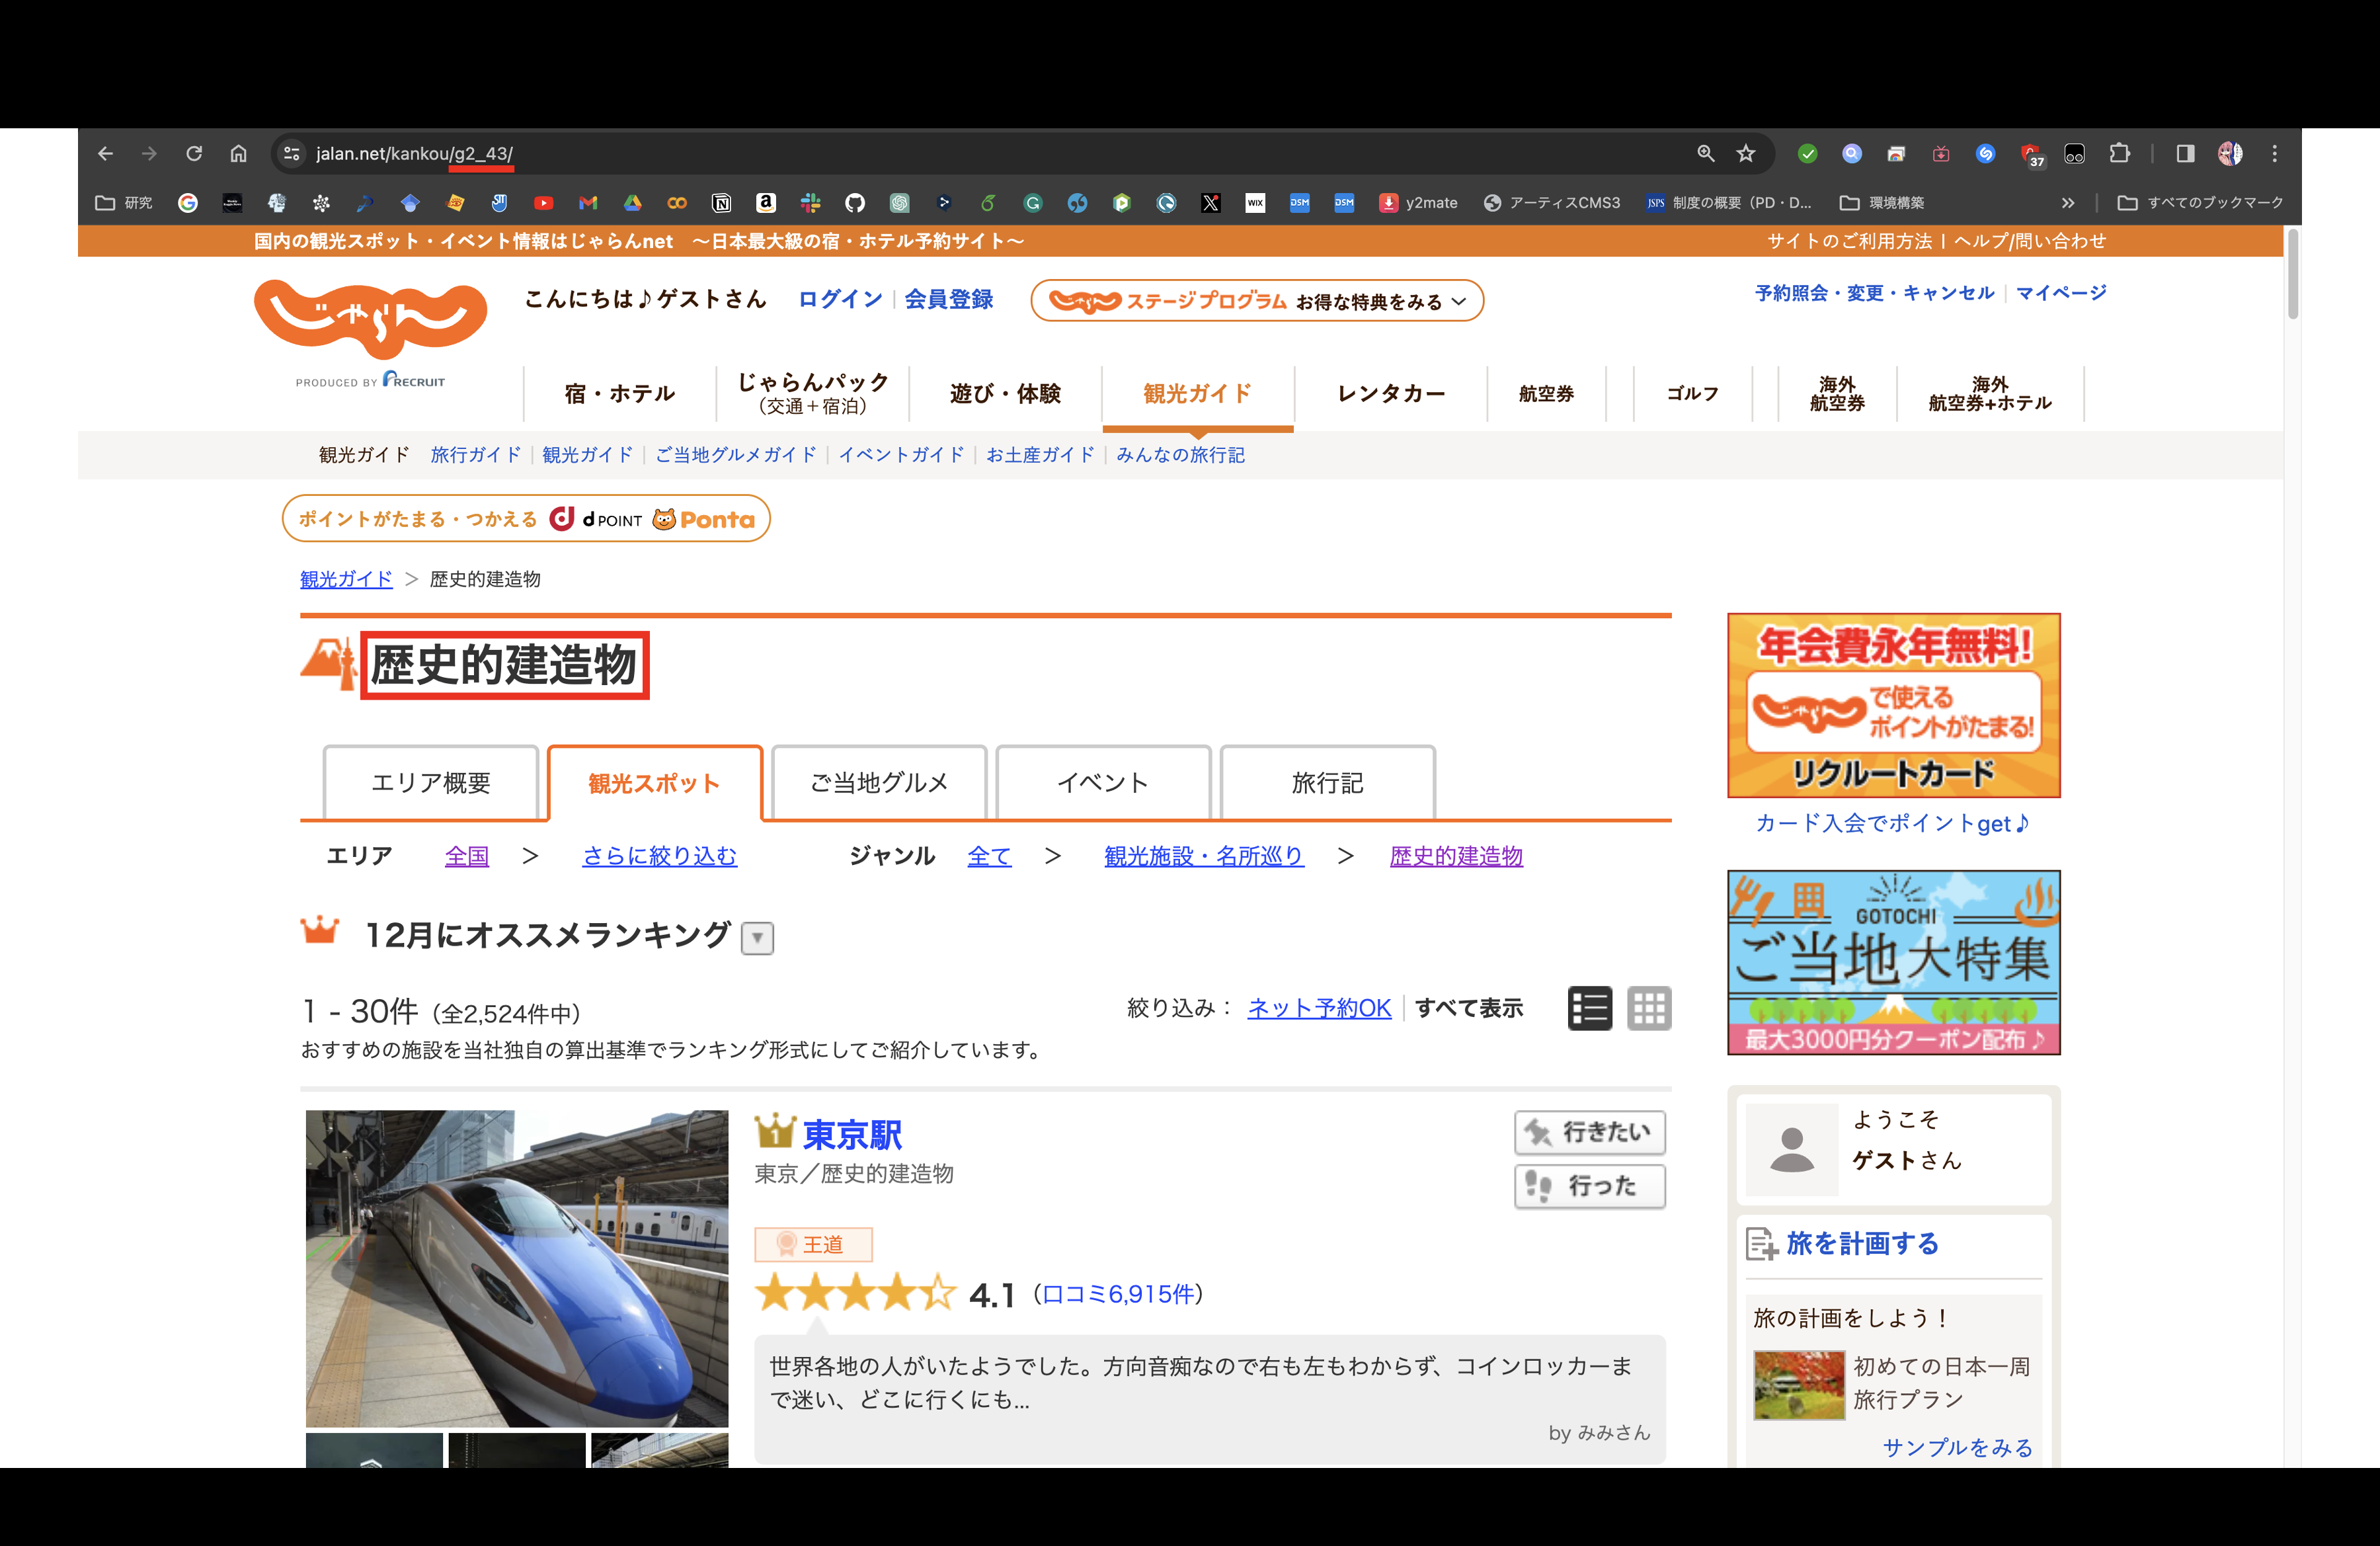

In [ ]:
# 保存先のディレクトリを指定
target_dir = "/content/drive/MyDrive/jalan_review/"
if not os.path.exists(target_dir):
    os.mkdir(target_dir)

# スクレイピングするカテゴリのIDを指定
IDs = ["g2_d0", "g2_83", "g2_c1", "g2_c4", "g2_84", "g2_82", "g2_27", "g2_20", "g2_24", "g2_30", "g2_35", "g2_36", "g2_41", "g2_43", "g2_45", "g2_53", "g2_54", "g2_67", "g2_c8", "g2_d1",
       "g2_56", "g2_V8", "g2_V9", "g2_48", "g2_72", "g2_51", "g2_74", "g2_37", "g2_46", "g2_57", "g2_49", "g2_U2", "g2_58"]

home_url = 'https://www.jalan.net/'
headers = {
      "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36",
      "referer" : home_url
}

for ID in IDs:
    URL = f"https://www.jalan.net/kankou/{ID}/"

    res = requests.get(URL, headers = headers)
    res.encoding = "shift_jis"
    row_html = html.fromstring(res.text.replace("\t", "").replace("\n", ""))
    # カテゴリ名を取得
    category_name = row_html.xpath('//*[@id="contentsListHeader"]/div/h1/text()')[0]

    # 保存先のディレクトリを作成
    if not os.path.exists(f"{target_dir}{category_name}"):
        os.mkdir(f"{target_dir}{category_name}")

    # 既にそのカテゴリについてスクレイピング済みの場合，続きから始める
    if os.path.exists(f"{target_dir}{category_name}/last_page.json"):
        with open(f"{target_dir}{category_name}/last_page.json", "r") as f:
            page_num = json.load(f) + 1
    else:
        page_num = 1

    while True:

        URL = f"https://www.jalan.net/kankou/{ID}/page_{page_num}"

        res = requests.get(URL, headers = headers)
        res.encoding = "shift_jis"
        row_html = html.fromstring(res.text.replace("\t", "").replace("\n", ""))

        spot_links = row_html.xpath('//*[@id="cassetteType"]/li[*]/div/div[*]/p[1]/a/@href')
        spot_names = row_html.xpath('//*[@id="cassetteType"]/li[*]/div/div[*]/p[1]/a/text()')

        # スクレイピングできる観光地がない場合終了
        if len(spot_links) == 0: break

        for spot_link, spot_name in zip(spot_links, spot_names):

            spot_name = spot_name.replace("/", "_")

            P = re.search(r"spt_\d+[a-zA-Z]{2,}\d+", spot_link)
            # 観光地でない(広告)場合スキップ
            if P is None: continue

            spot_id = P.group()

            target_path = f"{target_dir}{category_name}/{spot_id}_{spot_name}.json"
            # スクレイピング済みの場合スキップ
            if os.path.exists(target_path): continue

            # 観光地のトップページを取得
            URL = f'https://www.jalan.net/kankou/{spot_id}/'

            res = requests.get(URL, headers = headers)
            res.encoding = "shift_jis"
            row_html = html.fromstring(res.text.replace("", "").replace("\t", "").replace("\n", ""))

            # 観光地ページにフォーマットが3種類あるので処理を分岐
            try:
                adress = row_html.xpath('//*[@id="detailMap"]/text()')[0]
                areas = row_html.xpath('//*[@id="detailHeader"]/div[1]/div[3]/dl[1]/dd[*]/div[1]/a/text()')
                genre = row_html.xpath('//*[@id="detailHeader"]/div[1]/div[3]/dl[2]/dd/ul/li[2]/div[1]/a/text()')[0]
                parent_genre = row_html.xpath('//*[@id="detailHeader"]/div[1]/div[3]/dl[2]/dd/ul/li[1]/div[1]/a/text()')[0]
            except:
                try:
                    adress = row_html.xpath('//*[@id="detailMap"]/text()')[0]
                    areas = row_html.xpath('//*[@id="detailHeader"]/div[1]/div[2]/dl[1]/dd/ul/li[*]/div[1]/text()')
                    genre = row_html.xpath('//*[@id="detailHeader"]/div[1]/div[2]/dl[2]/dd/ul/li[2]/div[1]/text()')[0]
                    parent_genre = row_html.xpath('//*[@id="detailHeader"]/div[1]/div[2]/dl[2]/dd/ul/li[1]/div[1]/text()')[0]
                except:
                    adress = row_html.xpath('//*[@id="detailMap"]/text()')[0]
                    areas = row_html.xpath('//*[@id="detailHeader"]/div[1]/div[2]/dl[1]/dd/ul/li[*]/div[1]/text()')
                    genre = row_html.xpath('//*[@id="detailHeader"]/div[1]/div/dl[2]/dd/ul/li[2]/div[1]/text()')[0]
                    parent_genre = row_html.xpath('//*[@id="detailHeader"]/div[1]/div/dl[2]/dd/ul/li[1]/div[1]/text()')[0]

            reviews = list()

            # カテゴリ名と観光地のジャンルが異なる場合スキップ
            if genre != category_name: continue

            review_page_num = 1

            while True:
                URL = f'https://www.jalan.net/kankou/{spot_id}/kuchikomi/page_{review_page_num}'

                res = requests.get(URL, headers = headers)
                res.encoding = "shift_jis"
                row_html = html.fromstring(res.text.replace("", "").replace("\t", "").replace("\n", ""))

                # レビューボックスを取得
                boxes = row_html.xpath('//*[@id="reviewArea"]/ul/li[*]')

                # スクレイピングできるレビューがない場合終了
                if len(boxes) == 0: break

                # 全てのボックスについてレビューやタイトルを取得する
                for B in boxes:
                    # タイトルのないレビューがあるので処理を分岐
                    try:
                        star = float(B.xpath('./div/div[1]/div[1]/span[2]/text()')[0])
                        review = B.xpath('./div/div[1]/div[2]/div/span//text()')[-1]
                        title = B.xpath('./div/div[1]/p/a/text()')[0]
                        tag = B.xpath('./div/div[1]/ul[1]/li/text()')[0]
                        auther_type = B.xpath('./div/div[*]/p[2]/span/text()')[-1]
                        posted_date = B.xpath('./div/div[1]/ul[2]/li/text()')[-1][4:]
                    except:
                        star = float(B.xpath('./div/div[1]/div[1]/span[2]/text()')[0])
                        review = B.xpath('./div/div[1]/div[2]/div/span/text()')[-1]
                        tag = B.xpath('./div/div[1]/ul[1]/li/text()')[0]
                        auther_type = B.xpath('./div/div[*]/p[2]/span/text()')[-1]
                        posted_date = B.xpath('./div/div[1]/ul[2]/li/text()')[-1][4:]
                        auther_name = B.xpath('./div/div[2]/p[1]/img/@alt')[0]
                        title = f"{auther_name}さんの{spot_name}のクチコミ"

                    reviews.append( {
                        "title" : title,
                        "review" : review,
                        "posted_data" : posted_date,
                        "star" : star,
                        "tag" : tag,
                        "auther_type" : auther_type
                    } )

                review_page_num += 1

                sys.stdout.write('\r')
                sys.stdout.write(f"{category_name} : {page_num}, {spot_name} : {len(reviews)}")
                sys.stdout.flush()

            with open(target_path, "w") as f:
                json.dump( {
                    "spot_name" : spot_name,
                    "spot_id" : spot_id,
                    "adress" : adress,
                    "areas" : areas,
                    "category" : genre,
                    "parent_category" : parent_genre,
                    "reviews" : reviews
                }, f )

        with open(f"{target_dir}{category_name}/last_page.json", "w") as f:
            json.dump(page_num, f)

        page_num += 1



動物園・植物園 : 163, おふさ観音バラまつり : 15